## Introduce

## Import and setting

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader

import time
import warnings

grey = .77, .77, .77


print('set up complete!')

set up complete!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Fit distribution

In [0]:
# Create models from data
def fit_distribution(data, DISTRIBUTIONS, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0   

    good_dists = []

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        # plt.plot(x, pdf, label='{}'.format(distribution.name))                     
                        pd.Series(pdf, x).plot(ax=ax, label='{}'.format(distribution.name))
                        pass
                    end
                except Exception:
                    pass
                 
                good_dists.append((distribution.name, sse))

        except Exception:
            pass


    return good_dists

### Choose good distribution

In [0]:
# Create models from data
def good_distribution(data, DISTRIBUTIONS, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0   

    # Compute norm sse:
    norm_loc, norm_scale = st.norm.fit(data)
    norm_pdf = st.norm.pdf(x, loc=norm_loc, scale=norm_scale)
    norm_sse = np.sum(np.power(y - norm_pdf, 2.0))
    norm_dist = [(st.norm, norm_sse)]

    # Distribution is fitter than norm
    more_than_norm_dists = []
    more_than_norm_params = []

    # Distribution is not as fit as norm
    less_than_norm_dists = []
    less_than_norm_params = []

    # best & worst distribution
    best_distributions = []
    worst_distributions = []

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        # plt.plot(x, pdf, label='{}'.format(distribution.name))                     
                        pd.Series(pdf, x).plot(ax=ax, label='{}'.format(distribution.name))
                        pass
                    end
                except Exception:
                    pass
                 
                # identify if this distribution is better
                if norm_sse > sse > 0:
                    more_than_norm_dists.append((distribution, sse))
                    more_than_norm_params.append(params)

                # identify if this distribution is worse
                if sse > norm_sse > 0:
                    less_than_norm_dists.append((distribution, sse))
                    less_than_norm_params.append(params)

                # print('huyyyyy')
                  

        except Exception:
            pass

    

   # compute best distribution is fitter than norm
    best_sses = sorted([sse for dist, sse in more_than_norm_dists])
    if len(best_sses) == 1:
        best_distributions += [(dist, sse) for dist, sse in more_than_norm_dists if sse == best_sses[0]]
    elif len(best_sses) == 2:
        best_distributions += [(dist, sse) for dist, sse in more_than_norm_dists if sse == best_sses[0]] 
        best_distributions += [(dist, sse) for dist, sse in more_than_norm_dists if sse == best_sses[1]]
    elif len(best_sses) > 2:
        best_distributions += [(dist, sse) for dist, sse in more_than_norm_dists if sse == best_sses[0]] 
        best_distributions += [(dist, sse) for dist, sse in more_than_norm_dists if sse == best_sses[1]]
        # best_distributions += [(dist, sse) for dist, sse in more_than_norm_dists if sse == best_sses[2]] 

    # compute best distribution is not as fit as norm
    worst_sses = sorted([sse for dist, sse in less_than_norm_dists])
    if len(worst_sses) == 1:
        worst_distributions += [(dist, sse) for dist, sse in less_than_norm_dists if sse == worst_sses[0]]
    elif len(worst_sses) > 1:
        worst_distributions += [(dist, sse) for dist, sse in less_than_norm_dists if sse == worst_sses[0]] 
        # worst_distributions += [(dist, sse) for dist, sse in less_than_norm_dists if sse == worst_sses[1]]

    return (best_distributions + worst_distributions + norm_dist)

### Compute VaR

In [0]:
def compute_VaR(distribution, data, date, n_days_calc_var=250, level_meaning=0.05, n_iters = 10, last_k_days = 1):

    n_days = data.shape[0]
    var_monte = []

    n_error = -1
    loss_accuracy = -1.0
    last_var = 0

    loss_lastkdays =  -1.0
    tssl = pd.DataFrame()
    
    try:
        # Ignore warnings from data that can't be fit
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            
            for i in range(0, n_days - n_days_calc_var):
                var_1_time = []
                
                params = distribution.fit(data.iloc[i : i+n_days_calc_var])
                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                for _ in range(n_iters):
                    # Calculate fitted PDF and error with fit in distribution
                    monte_carlo = distribution.rvs(loc=loc, scale=scale, size = n_days_calc_var, *arg, random_state=None)
                    serie = pd.Series(monte_carlo)            
                    var_1_time.append(serie.quantile(level_meaning))

                var_monte.append(sum(var_1_time) / n_iters)

            var_monte_array = np.array(var_monte)
            tssl_array = np.array(data.iloc[n_days_calc_var:n_days])

            if last_k_days == 0:
                loss_accuracy = np.round(sum(var_monte_array > tssl_array) / (len(var_monte_array) * level_meaning), 3)
                n_error = sum(var_monte_array > tssl_array)
               
            elif last_k_days > 0:
                loss_accuracy = np.round(sum(var_monte_array[0:-last_k_days] > tssl_array[0:-last_k_days]) / (len(var_monte_array) * level_meaning), 3)
                n_error = sum(var_monte_array[0:-last_k_days] > tssl_array[0:-last_k_days]) 
                loss_lastkdays = np.round(sum(var_monte_array[-1: -last_k_days-1:-1] > tssl_array[-1: -last_k_days-1:-1]) , 3) / last_k_days
            
            tssl['Date'] = pd.Series(np.array(date.iloc[n_days_calc_var:n_days]))
            tssl['Monte_carlo'] = pd.Series(var_monte_array)
            tssl['TSSL'] = pd.Series(tssl_array)
            tssl['Error'] = tssl['Monte_carlo'] > tssl['TSSL']
            last_var = var_monte_array[-1-last_k_days-1]
            
            
    except Exception:
        pass

    return (loss_accuracy, n_error, last_var), loss_lastkdays, tssl
    

## Value at risk

### Read data & preprocessing


In [6]:

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2010-01-01'
end_date = '2019-12-31'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
N225 = pandas_datareader.data.DataReader('^N225', 'yahoo', start_date, end_date)
N225.to_csv('z.csv')
snp = pd.read_csv('z.csv', index_col=False)
data = None
data = snp.iloc[-1:0:-1].copy()

# Add profit rate column
profit_rate = []
for i in range(len(data)-1):
    profit_rate.append(data.Close.iloc[i] / data.Close.iloc[i+1] - 1)
profit_rate.append(0)
data['Profit_rate'] = profit_rate
if data.Profit_rate.isnull().any() or data.index.isnull().any():
    print('add profit rate column badly')
else:
    print('add profit rate column successfully')


data

add profit rate column successfully


,Date,High,Low,Open,Close,Volume,Adj Close,Profit_rate
2448,2019-12-30,23782.490234,23656.619141,23770.929688,23656.619141,41600.0,23656.619141,-0.007597
2447,2019-12-27,23967.179688,23837.720703,23953.750000,23837.720703,44800.0,23837.720703,-0.003645
2446,2019-12-26,23931.509766,23775.400391,23787.699219,23924.919922,40300.0,23924.919922,0.005973
2445,2019-12-25,23824.849609,23782.869141,23813.589844,23782.869141,31600.0,23782.869141,-0.002002
2444,2019-12-24,23853.560547,23796.349609,23839.179688,23830.580078,37900.0,23830.580078,0.000398
...,...,...,...,...,...,...,...,...
5,2010-01-12,10905.389648,10763.679688,10770.349609,10879.139648,192800.0,10879.139648,0.007484
4,2010-01-08,10816.450195,10677.559570,10743.299805,10798.320312,211800.0,10798.320312,0.010922
3,2010-01-07,10774.000000,10636.669922,10742.750000,10681.660156,182600.0,10681.660156,-0.004640
2,2010-01-06,10768.610352,10661.169922,10709.549805,10731.450195,181800.0,10731.450195,0.004645


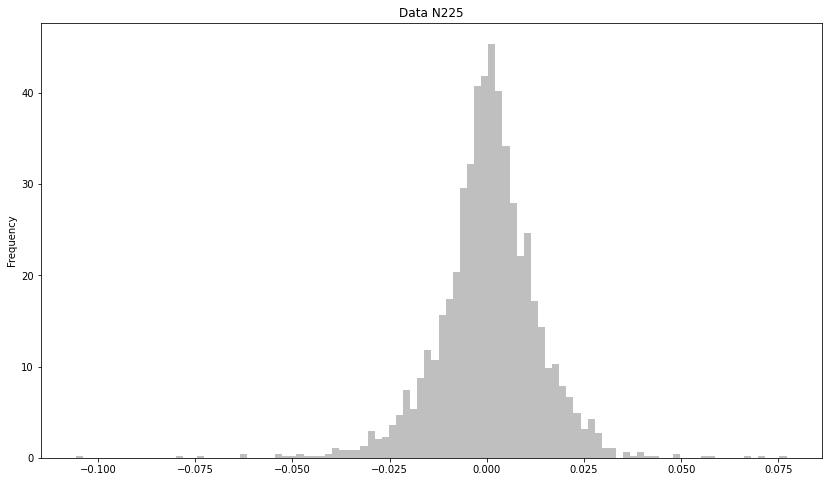

In [7]:
matplotlib.rc('figure', figsize=(14, 8))
ax = data.Profit_rate.plot(kind='hist', bins=100, density=True, alpha=0.5, color='grey', 
                           edgecolor='none', title='Data N225')
plt.show()

### Anderson test N225

In [8]:
from scipy.stats import anderson
(statistic, critical_values, significance_level) = anderson(data.Profit_rate, dist='norm')
# result = anderson(data)
print('Statistic: %.3f' % statistic)
p = 0
for i in range(len(critical_values)):
	sl, cv = significance_level[i], critical_values[i]
	if statistic < critical_values[i]:
		print('%.3f: %.3f, data looks normal' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal' % (sl, cv))

Statistic: 18.729
15.000: 0.575, data does not look normal
10.000: 0.655, data does not look normal
5.000: 0.786, data does not look normal
2.500: 0.917, data does not look normal
1.000: 1.090, data does not look normal


### Fit distribution

In [9]:
# Find best fit distribution
DISTRIBUTIONS = [st.t, st.logistic, st.dgamma, st.laplace, st.hypsecant,
                 st.dweibull, st.pearson3, st.gumbel_l, st.gumbel_r, st.norm]



good_dists_sses = fit_distribution(data.Profit_rate, DISTRIBUTIONS, 500)

good_dists_sorted = sorted([(dist, sse) for dist, sse in good_dists_sses], key=lambda x: x[1])
fit_dists = pd.DataFrame({'n225': [dist for dist, sse in good_dists_sorted]})
fit_dists['n225 lost square'] = pd.DataFrame([sse for dist, sse in good_dists_sorted])
fit_dists.to_csv('n225_fit.csv')
fit_dists

,n225,n225 lost square
0,dweibull,3420.511222
1,dgamma,3483.533326
2,laplace,3599.718710
3,hypsecant,3683.947900
4,t,3746.873592
5,logistic,4355.651381
6,pearson3,7207.247768
7,norm,7312.328922
8,gumbel_l,16317.443765
9,gumbel_r,22852.251565


### Choose 4 good distribution, 2>norm>2

In [0]:
# Find best fit distribution
DISTRIBUTIONS = [st.t, st.logistic, st.dgamma, st.laplace, st.hypsecant,
                 st.dweibull, st.pearson3, st.gumbel_l, st.gumbel_r, st.norm]


### Plot data with distribution

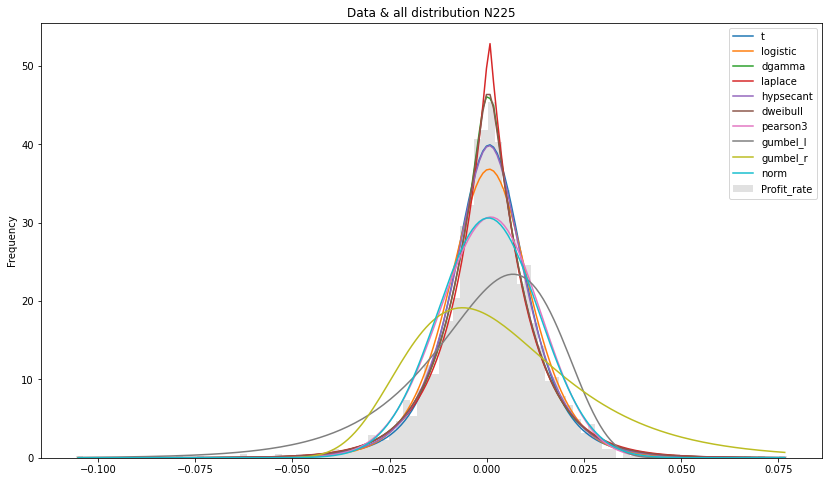

In [0]:
matplotlib.rc('figure', figsize=(14, 8))
ax = data.Profit_rate.plot(kind='hist', bins=100, density=True, alpha=0.5, color=grey, 
                           edgecolor='none', title='Data & all distribution N225')
dist = good_distribution(data.Profit_rate, DISTRIBUTIONS, 200, ax=ax)
plt.legend(loc='best')
plt.show()

### Compute VaR and VR test

In [0]:
start_time = time.time()

last_k_days = 0
level_meanings = [0.05, 0.01]
n_iters = 100
n_days_calc_var = 1000

result = pd.DataFrame({'Distribution':[dist.name for dist in DISTRIBUTIONS]})
result['N_days'] = pd.Series([data.shape[0] - n_days_calc_var for dist in DISTRIBUTIONS])

tssl= {}
tssl[0.05] = {}
tssl[0.01] = {}

print('Data: N225')
print('Date: {} to {}'.format(data.Date.iloc[-1], data.Date.iloc[0]))
print('----------------------------------------------')

for level_meaning in level_meanings:
    vr_losses = []
    n_errors = [] 
    last_vars = []
    
    for dist in DISTRIBUTIONS:
        (vr_loss, n_error, last_var), _, tssl[level_meaning][dist.name] = compute_VaR(dist, data.Profit_rate.iloc[::-1], data.Date.iloc[::-1], n_days_calc_var=n_days_calc_var, 
                                                                                 n_iters = n_iters, level_meaning=level_meaning, last_k_days = last_k_days)
        vr_losses.append(vr_loss)
        n_errors.append(n_error)
        last_vars.append(last_var)

    result['VR loss {}%'.format(level_meaning*100)] = pd.Series(vr_losses)
    result['Number error VaR {}%'.format(level_meaning*100)] = pd.Series(n_errors)
    result['Last VaR {}%'.format(level_meaning*100)] = pd.Series(last_vars)

print('total time train: {} (s)'.format(time.time() - start_time))
print('VR test loss_accuracy with monte carlo {} times :'.format(n_iters))
result['Last VaR Point 1%'] = (result['Last VaR {}%'.format(0.01*100)] + 1) * data.Close.iloc[1]
result['Last VaR Point 5%'] = (result['Last VaR {}%'.format(0.05*100)] + 1) * data.Close.iloc[1]
result['Last profit rate Point '] = data.Close.iloc[0]
result


Data: N225
Date: 2010-01-05 to 2019-12-30
----------------------------------------------
total time train: 3068.061437368393 (s)
VR test loss_accuracy with monte carlo 100 times :


,Distribution,N_days,VR loss 5.0%,Number error VaR 5.0%,Last VaR 5.0%,VR loss 1.0%,Number error VaR 1.0%,Last VaR 1.0%,Last VaR Point 1%,Last VaR Point 5%,Last profit rate Point
0,t,1448,1.050,76,-0.016872,1.036,15,-0.033310,23043.690381,23435.534516,23656.619141
1,logistic,1448,1.050,76,-0.016939,1.312,19,-0.026603,23203.563575,23433.940191,23656.619141
2,dgamma,1448,0.967,70,-0.018265,1.036,15,-0.030661,23106.836089,23402.326717,23656.619141
3,laplace,1448,0.912,66,-0.018100,0.967,14,-0.030954,23099.844268,23406.260023,23656.619141
4,hypsecant,1448,1.036,75,-0.017234,1.036,15,-0.027645,23178.733603,23426.895921,23656.619141
5,dweibull,1448,0.953,69,-0.018064,1.036,15,-0.030838,23102.624655,23407.120270,23656.619141
6,pearson3,1448,0.815,59,-0.019529,1.450,21,-0.027704,23177.310430,23372.186296,23656.619141
7,gumbel_l,1448,0.166,12,-0.040523,0.069,1,-0.065137,22284.993017,22871.740247,23656.619141
8,gumbel_r,1448,0.539,39,-0.024237,1.381,20,-0.031438,23088.311910,23259.973516,23656.619141
9,norm,1448,0.870,63,-0.019450,1.727,25,-0.027439,23183.632418,23374.086811,23656.619141


### Plot result

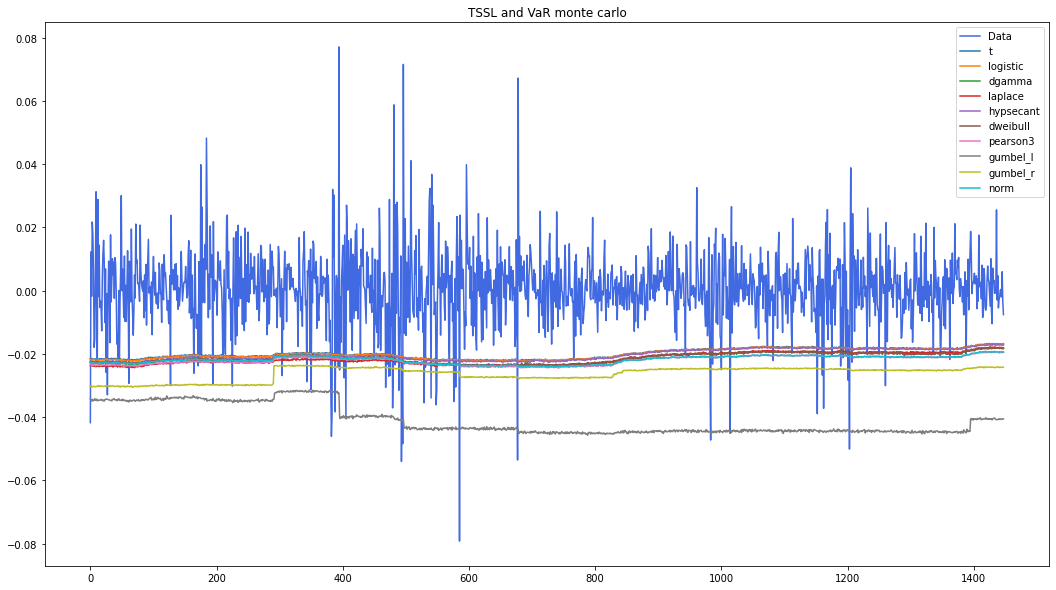

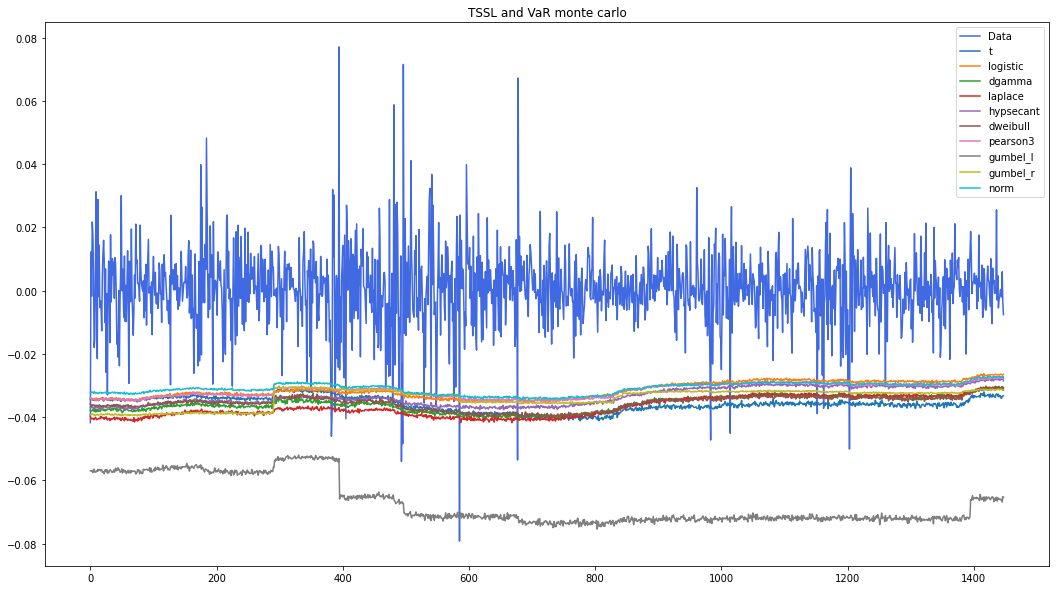

In [0]:

# Adjusting the size of matplotlib
import matplotlib as mpl
# matplotlib.style.use('default')
mpl.rc('figure', figsize=(18, 10))
mpl.__version__

# Adjusting the style of matplotlib



# .Profit_rate.iloc[1001:].plot(label='hi', color='royalblue')
# plt.legend()

for level_meaning in level_meanings:
    ax = data.iloc[:len(tssl[0.05][st.norm.name])].iloc[::-1].set_index(np.arange(len(tssl[0.05][st.norm.name]))).Profit_rate.plot(title='TSSL and VaR monte carlo', label='Data', color='royalblue')

    for dist in DISTRIBUTIONS:
        tssl[level_meaning][dist.name].Monte_carlo.plot(ax = ax, label='{}'.format(dist.name))
    plt.legend(loc='best')
    plt.show()

### Save result

In [0]:
data[['Date', 'Close', 'Profit_rate']].describe().to_csv('N225_describe.csv')
result.to_csv('N225result.csv')
for level_meaning in level_meanings:
    for dist in DISTRIBUTIONS:
        tssl[level_meaning][dist.name].to_csv('huyto/N225_{}%_{}.csv'.format(level_meaning, dist.name))
!zip -r /content/huyto.zip /content/huyto

  adding: content/huyto/ (stored 0%)
  adding: content/huyto/N225_0.01%_logistic.csv (deflated 62%)
  adding: content/huyto/N225_0.05%_norm.csv (deflated 62%)
  adding: content/huyto/N225_0.05%_gumbel_r.csv (deflated 62%)
  adding: content/huyto/N225_0.01%_dweibull.csv (deflated 62%)
  adding: content/huyto/N225_0.01%_laplace.csv (deflated 62%)
  adding: content/huyto/N225_0.01%_pearson3.csv (deflated 62%)
  adding: content/huyto/N225_0.01%_t.csv (deflated 62%)
  adding: content/huyto/N225_0.05%_hypsecant.csv (deflated 62%)
  adding: content/huyto/N225_0.05%_t.csv (deflated 62%)
  adding: content/huyto/N225_0.05%_laplace.csv (deflated 62%)
  adding: content/huyto/N225_0.01%_hypsecant.csv (deflated 62%)
  adding: content/huyto/N225_0.05%_dgamma.csv (deflated 62%)
  adding: content/huyto/N225_0.05%_gumbel_l.csv (deflated 62%)
  adding: content/huyto/N225_0.01%_gumbel_l.csv (deflated 62%)
  adding: content/huyto/N225_0.01%_gumbel_r.csv (deflated 62%)
  adding: content/huyto/N225_0.05%_dwe